In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import scale

from keras.models import Sequential
from keras.layers import Dense, Dropout

from keras.layers.normalization import BatchNormalization
from keras.initializers import Initializer
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model


Using TensorFlow backend.


In [2]:
raw_data = pd.read_csv('./data/ordered_molecules.csv')

In [3]:
raw_data.head()

,time,molecule,px,py,pz,ax,ay,az
0,0,1,0.27497,0.22765,0.40548,1.185458,-1.527830,-4.614324
1,0,2,2.13410,1.61428,1.62211,-4.601109,-0.659241,1.090967
2,0,3,12.05408,12.60878,2.90295,4.530882,-2.598597,2.008448
3,0,4,0.85376,1.93829,4.87515,3.975239,0.917088,-2.261618
4,0,5,12.70257,0.12956,6.09076,-1.861295,-0.908830,5.337542


In [4]:
raw_data.iloc[:,2:] = scale(raw_data.iloc[:,2:], axis = 0)

In [5]:
raw_data_scaled = raw_data

In [6]:
raw_data_scaled.head()

,time,molecule,px,py,pz,ax,ay,az
0,0,1,-1.644088,-1.687248,-1.622801,0.433043,-0.557533,-1.614066
1,0,2,-1.146260,-1.315603,-1.297500,-1.680760,-0.240568,0.381615
2,0,3,1.510062,1.631154,-0.955030,1.655108,-0.948277,0.702545
3,0,4,-1.489103,-1.228761,-0.427706,1.452135,0.334665,-0.791101
4,0,5,1.683712,-1.713539,-0.102678,-0.679920,-0.331648,1.867045


In [7]:
target_data = raw_data_scaled.iloc[128:,2:]
data = pd.concat([raw_data_scaled.iloc[0:255872,:].reset_index(drop=True), target_data.reset_index(drop=True)], axis = 1, ignore_index=True)

In [8]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0,1,-1.644088,-1.687248,-1.622801,0.433043,-0.557533,-1.614066,-1.643419,-1.687447,-1.623753,0.428789,-0.562693,-1.620018
1,0,2,-1.146260,-1.315603,-1.297500,-1.680760,-0.240568,0.381615,-1.146375,-1.313517,-1.298369,-1.706684,-0.293925,0.372428
2,0,3,1.510062,1.631154,-0.955030,1.655108,-0.948277,0.702545,1.510726,1.631180,-0.957386,1.618997,-0.952184,0.774350
3,0,4,-1.489103,-1.228761,-0.427706,1.452135,0.334665,-0.791101,-1.487831,-1.228078,-0.426671,1.405047,0.302387,-0.800858
4,0,5,1.683712,-1.713539,-0.102678,-0.679920,-0.331648,1.867045,1.683602,-1.713879,-0.101376,-0.654165,-0.308364,1.838234


In [9]:
diff_x = data.iloc[:,8] - data.iloc[:,2]
diff_y = data.iloc[:,9] - data.iloc[:,3]
diff_z = data.iloc[:,10] - data.iloc[:,4]


diff_x_idx, = np.where(abs(diff_x) > 3)
diff_y_idx, = np.where(abs(diff_y) > 3)
diff_z_idx, = np.where(abs(diff_z) > 3)

diff_idx = set(diff_x_idx) | set(diff_y_idx) | set(diff_z_idx)

final_data = data.loc[data.index.drop(list(diff_idx))]

In [10]:
x_train, x_test, y_train, y_test = train_test_split(final_data.iloc[:,2:8], 
                                                    final_data.iloc[:,8:], 
                                                    test_size = 0.3, random_state = 10)

In [11]:
#model 1
model_1 = Sequential()

model_1.add(Dense(32, input_dim=6, activation='relu', kernel_initializer = 'he_normal', kernel_regularizer = regularizers.l2(0.01)))
model_1.add(BatchNormalization())

model_1.add(Dense(32, activation='relu', kernel_initializer = 'he_normal', kernel_regularizer = regularizers.l2(0.01)))
model_1.add(BatchNormalization())

model_1.add(Dense(32, activation='relu', kernel_initializer = 'he_normal', kernel_regularizer = regularizers.l2(0.01)))
model_1.add(BatchNormalization())

model_1.add(Dense(6, activation='linear', kernel_initializer = 'glorot_normal', kernel_regularizer = regularizers.l2(0.01)))

In [12]:
model_1.compile(loss='mean_absolute_error', optimizer= "rmsprop", metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=20, mode='min')
model_check_point = ModelCheckpoint('./model/DNN_BN.h5', monitor = 'val_loss', verbose=2, save_best_only=True)
callback_list = [model_check_point, early_stop]

In [13]:
hist_1 = model_1.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=150, batch_size=64, callbacks = callback_list)

Train on 178881 samples, validate on 76664 samples
Epoch 1/150
178881/178881 [==============================] - 10s 54us/step - loss: 0.3675 - mean_absolute_error: 0.1742 - val_loss: 0.1307 - val_mean_absolute_error: 0.1038

Epoch 00001: val_loss improved from inf to 0.13073, saving model to ./model/DNN_BN.h5
Epoch 2/150
178881/178881 [==============================] - 8s 46us/step - loss: 0.1644 - mean_absolute_error: 0.1422 - val_loss: 0.1192 - val_mean_absolute_error: 0.0996

Epoch 00002: val_loss improved from 0.13073 to 0.11923, saving model to ./model/DNN_BN.h5
Epoch 3/150
178881/178881 [==============================] - 8s 47us/step - loss: 0.1548 - mean_absolute_error: 0.1368 - val_loss: 0.0870 - val_mean_absolute_error: 0.0701

Epoch 00003: val_loss improved from 0.11923 to 0.08697, saving model to ./model/DNN_BN.h5
Epoch 4/150
178881/178881 [==============================] - 8s 46us/step - loss: 0.1492 - mean_absolute_error: 0.1334 - val_loss: 0.0703 - val_mean_absolute_error

In [11]:
model = load_model('./model/DNN_BN.h5')

In [12]:
y_pred = model.predict(x_test)

In [13]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae_metric = mean_absolute_error(y_test, y_pred)
r2_error = r2_score(y_test, y_pred)

In [14]:
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae_metric)
print("R2_Score:", r2_error)

MSE:  0.0030698972861182374
RMSE:  0.05540665380726612
MAE:  0.04252060348393475
R2_Score: 0.996926668798602


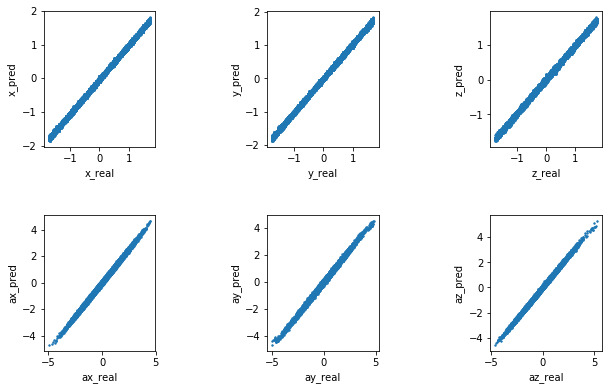

In [15]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(3,3,1)
ax2 = fig.add_subplot(3,3,2)
ax3 = fig.add_subplot(3,3,3)
ax4 = fig.add_subplot(3,3,4)
ax5 = fig.add_subplot(3,3,5)
ax6 = fig.add_subplot(3,3,6)

ax1.scatter(y_test.values[:,0], y_pred[:,0], s= 2)
ax1.set_xlabel('x_real')
ax1.set_ylabel('x_pred')
ax2.scatter(y_test.values[:,1], y_pred[:,1], s= 2)
ax2.set_xlabel('y_real')
ax2.set_ylabel('y_pred')
ax3.scatter(y_test.values[:,2], y_pred[:,2], s= 2)
ax3.set_xlabel('z_real')
ax3.set_ylabel('z_pred')
ax4.scatter(y_test.values[:,3], y_pred[:,3], s= 2)
ax4.set_xlabel('ax_real')
ax4.set_ylabel('ax_pred')
ax5.scatter(y_test.values[:,4], y_pred[:,4], s= 2)
ax5.set_xlabel('ay_real')
ax5.set_ylabel('ay_pred')
ax6.scatter(y_test.values[:,5], y_pred[:,5], s= 2)
ax6.set_xlabel('az_real')
ax6.set_ylabel('az_pred')

plt.subplots_adjust(wspace = 1, hspace = 0.5)
plt.show()

In [20]:
# plot history
plt.plot(hist_1.history['loss'], label='train')
plt.plot(hist_1.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'hist_1' is not defined

In [16]:
#cross validation

kfold = KFold(n_splits=20, shuffle=True, random_state = 500)
X = final_data.iloc[:,2:8]
Y = final_data.iloc[:,8:]

cv_rmse = []
cv_mae = []
cv_r2 = []

for train, test in kfold.split(X, Y):
    
    # evaluate the model
    pred = model.predict(X.iloc[test,:])
    
    rmse = np.sqrt(mean_squared_error(Y.iloc[test,:], pred))
    mae = mean_absolute_error(Y.iloc[test,:], pred)
    r2 = r2_score(Y.iloc[test,:], pred)
    
    cv_rmse.append(rmse)
    cv_mae.append(mae)
    cv_r2.append(r2)

In [17]:
print(np.mean(cv_rmse))
print(np.std(cv_rmse))
print('\n')

print(np.mean(cv_mae))
print(np.std(cv_mae))
print('\n')

print(np.mean(cv_r2))
print(np.std(cv_r2))

0.055404173304510584
0.00019024198289931165


0.04250425183237194
0.00014539494579439666


0.9969294744946193
2.4147009065977242e-05


In [18]:
###############################################################################

원래 scale 로 변환

In [19]:
raw_data = pd.read_csv('./data/ordered_molecules.csv')

In [20]:
px_mean = np.mean(raw_data['px'])
px_std = np.std(raw_data['px'])
py_mean = np.mean(raw_data['py'])
py_std = np.std(raw_data['py'])
pz_mean = np.mean(raw_data['pz'])
pz_std = np.std(raw_data['pz'])

ax_mean = np.mean(raw_data['ax'])
ax_std = np.std(raw_data['ax'])
ay_mean = np.mean(raw_data['ay'])
ay_std = np.std(raw_data['ay'])
az_mean = np.mean(raw_data['az'])
az_std = np.std(raw_data['az'])

In [21]:
y_test.iloc[:,0] = y_test.iloc[:,0] * px_std + px_mean
y_test.iloc[:,1] = y_test.iloc[:,1] * py_std + py_mean
y_test.iloc[:,2] = y_test.iloc[:,2] * pz_std + pz_mean

y_test.iloc[:,3] = y_test.iloc[:,3] * ax_std + ax_mean
y_test.iloc[:,4] = y_test.iloc[:,4] * ay_std + ay_mean
y_test.iloc[:,5] = y_test.iloc[:,5] * az_std + az_mean


In [22]:
y_pred_df = pd.DataFrame(y_pred)

In [23]:
y_pred_df.iloc[:,0] = y_pred_df.iloc[:,0] * px_std + px_mean
y_pred_df.iloc[:,1] = y_pred_df.iloc[:,1] * py_std + py_mean
y_pred_df.iloc[:,2] = y_pred_df.iloc[:,2] * pz_std + pz_mean

y_pred_df.iloc[:,3] = y_pred_df.iloc[:,3] * ax_std + ax_mean
y_pred_df.iloc[:,4] = y_pred_df.iloc[:,4] * ay_std + ay_mean
y_pred_df.iloc[:,5] = y_pred_df.iloc[:,5] * az_std + az_mean

In [24]:
mse = mean_squared_error(y_test, y_pred_df)
rmse = np.sqrt(mse)
mae_metric = mean_absolute_error(y_test, y_pred_df)
r2_error = r2_score(y_test, y_pred_df)

In [25]:
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae_metric)
print("R2_Score:", r2_error)

MSE:  0.029494313215668717
RMSE:  0.17173908470604096
MAE:  0.13471714748190103
R2_Score: 0.9969266681155732


In [26]:
y_test

,8,9,10,11,12,13
216451,1.93464,2.77564,7.19014,5.052557,3.410067,3.556575
36605,12.34047,11.87384,7.53528,0.326219,-0.453539,0.243936
200500,2.33578,4.88586,6.10077,-1.869792,3.709122,1.326076
121391,3.43433,3.17563,10.90524,-1.457747,2.263259,0.815057
243246,11.64829,3.82942,8.38510,-2.036278,3.493320,-4.187458
186328,4.77522,8.17631,1.00259,-0.963637,0.891893,-1.005037
136623,3.08917,3.43311,10.68677,1.300316,2.504022,-5.222736
208250,10.87436,10.45825,2.80358,2.489527,0.294082,0.015685
30757,6.34425,2.06444,8.11773,-5.274699,0.369777,-0.015520
198277,1.02985,0.39150,8.97285,1.454083,2.734588,-2.769155


In [30]:
#cross validation

kfold = KFold(n_splits=20, shuffle=True, random_state = 500)
X = final_data.iloc[:,2:8]
Y = final_data.iloc[:,8:]

cv_rmse = []
cv_mae = []
cv_r2 = []

for train, test in kfold.split(X, Y):
    y_test = Y.iloc[test,:]

    y_test.iloc[:,0] = y_test.iloc[:,0] * px_std + px_mean
    y_test.iloc[:,1] = y_test.iloc[:,1] * py_std + py_mean
    y_test.iloc[:,2] = y_test.iloc[:,2] * pz_std + pz_mean

    y_test.iloc[:,3] = y_test.iloc[:,3] * ax_std + ax_mean
    y_test.iloc[:,4] = y_test.iloc[:,4] * ay_std + ay_mean
    y_test.iloc[:,5] = y_test.iloc[:,5] * az_std + az_mean
    
    y_pred = model.predict(X.iloc[test,:])
    y_pred_df = pd.DataFrame(y_pred)
    
    y_pred_df.iloc[:,0] = y_pred_df.iloc[:,0] * px_std + px_mean
    y_pred_df.iloc[:,1] = y_pred_df.iloc[:,1] * py_std + py_mean
    y_pred_df.iloc[:,2] = y_pred_df.iloc[:,2] * pz_std + pz_mean

    y_pred_df.iloc[:,3] = y_pred_df.iloc[:,3] * ax_std + ax_mean
    y_pred_df.iloc[:,4] = y_pred_df.iloc[:,4] * ay_std + ay_mean
    y_pred_df.iloc[:,5] = y_pred_df.iloc[:,5] * az_std + az_mean
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_df))
    mae = mean_absolute_error(y_test, y_pred_df)
    r2 = r2_score(y_test, y_pred_df)
    
    cv_rmse.append(rmse)
    cv_mae.append(mae)
    cv_r2.append(r2)

/usr/local/anaconda/envs/env_py3/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [31]:
print(np.mean(cv_rmse))
print(np.std(cv_rmse))
print('\n')

print(np.mean(cv_mae))
print(np.std(cv_mae))
print('\n')

print(np.mean(cv_r2))
print(np.std(cv_r2))

0.1717292540241969
0.0005681295826024924


0.1346639098858025
0.0004554075140078578


0.9969294738058411
2.4147014961791257e-05
